# Speckle project documentation (24-hours)

## Enter information:

In [14]:
video_time_length=60 #s
video_frame_numbers=1129 #frames
imgname='1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted/'

## Imports

In [15]:
%cd /Users/wenyun/Desktop/python/DSHpy-master 

# 2. install the project/module
!python setup.py install

# 3. Add the project directory to the path
import os, sys

sys.path.append(os.getcwd())

/Users/wenyun/Desktop/python/DSHpy-master
running install
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing DSH.egg-info/PKG-INFO
writing dependency_links to DSH.egg-info/dependency_links.txt
writing requirements to DSH.egg-info/requires.txt
writing top-level names to DSH.egg-info/top_level.txt
reading manifest file 'DSH.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'DSH.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build/bdist.macosx-10.9-

In [16]:
import speckle
from speckle.inference.read_in_data import read_in_data
from speckle.inference.correlation_heatmap import get_correlation,dump_heatmap,display_correlation_heatmaps,mask_heatmap,plot_radius_distribution
from speckle.inference.calculating_tau import objective, avg_correlation_single_px, plot_correlation_vs_lagtime,fit_exponential_decay, reconstruct,avg_correlation,calculate_correlation_pixel
from speckle.inference.dedrift import dedrift_videos

In [17]:
from PIL import Image
import numpy as np
from ellipse import LsqEllipse
from matplotlib.patches import Ellipse
from skimage import io
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks


from pandas import read_csv
from scipy.optimize import curve_fit

%matplotlib inline
import matplotlib.pyplot as plt
import os

import seaborn as sns
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import CorrMaps as CM

## Read in video

In [18]:
framespeed=video_time_length/video_frame_numbers

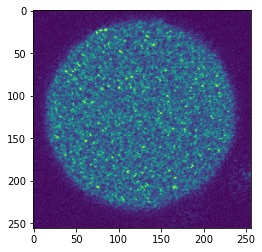

In [19]:
img=read_in_data(foldername,imgname)

## Dedrifting if necessary

In [7]:
particle_centers=foldername+"centers_7h.csv"

In [8]:
dedrift_videos(img,particle_centers,foldername,imgname)

FileNotFoundError: [Errno 2] File /Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted/centers_7h.csv does not exist: '/Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted/centers_7h.csv'

In [9]:
imgname=imgname+"_dedrifted"
img=read_in_data(foldername,imgname)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted/1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted_dedrifted.tif'

## setting up kernel and generate correlation maps

In [20]:
#info
kernel_size=5
laglist=list(range(1,900,1))
#test_ROI = [x,y,w,h]
testROI=[140,90,40,40]
tRange=None

In [21]:
## don't change please
def set_up_kernel(kernel_size):
    KernelSpecs = DSH.Kernel.Kernel()
    KernelSpecs.Initialize(shape=kernel_size, kernel_type='Gauss', params={'sigma':[kernel_size, kernel_size]}, padding=True)
    return KernelSpecs

def compute_correlation_maps(foldername, imgname, kernel, laglist, testROI=None, tRange=None):
    froot = os.path.join(foldername)
    fname = os.path.join(froot, imgname+'.raw')
    metadata_fname = os.path.join(froot, imgname+'.ini')
    
    mi_file = MI.MIfile(fname, metadata_fname)
    mi_file.OpenForReading()
    mi_file.Read(zRange=None, cropROI=None, closeAfter=False)
    mi_file.Close()
    
    position=str(testROI)+'_'+str(tRange)
    froot = os.path.join(foldername+imgname+'_'+position)
    #KernelSpecs.SetPadding(False)
    corrmap = CM.CorrMaps(mi_file, froot, laglist, kernel, imgRange=tRange, cropROI=testROI)
    
    cmap_list = corrmap.Compute(silent=False, return_maps=False)
    
def load_correlation_maps(foldername,imgname,testROI, tRange):
    froot = os.path.join(foldername+imgname+'_'+str(testROI)+'_'+str(tRange))
    corr_maps = CM.LoadFromConfig(os.path.join(froot, 'CorrMapsConfig.ini'), outFolder=froot)
    return corr_maps

In [22]:
kernel=set_up_kernel(kernel_size)

In [10]:
import csv
kernel_matrix=kernel.ToMatrix()

Text(0, 0.5, 'Intensity')

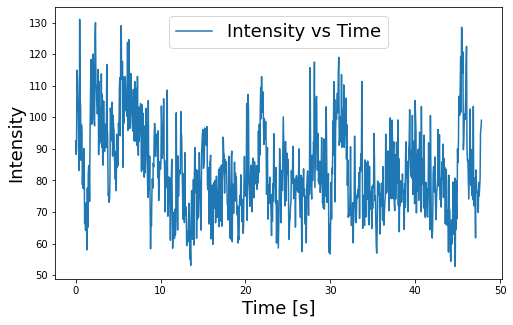

In [11]:
px=[153,100] #[y,x]
intensity=[]
t_range=range(0,900,1)
real_t= [element * framespeed for element in t_range]
for t in t_range:
    kerneled_intensity=0
    start_y=px[0]-math.floor(kernel_matrix.shape[0]/2)
    start_x=px[1]-math.floor(kernel_matrix.shape[1]/2)
    for y_i in range(0,kernel_matrix.shape[1],1):
        for x_i in range(0,kernel_matrix.shape[1],1):
            y_pixel=start_y+y_i
            x_pixel=start_x+x_i
            kerneled_intensity=kerneled_intensity+kernel_matrix[y_i,x_i]*img[t][y_pixel,x_pixel]
    intensity_t=kerneled_intensity
    intensity.append(intensity_t)

plt.figure(figsize=(8,5))
#plt.ylim([0, 255])
plt.plot(real_t,intensity,'-')
plt.legend(['Intensity vs Time'], fontsize=18)
plt.xlabel("Time [s]",fontsize=18)
plt.ylabel("Intensity",fontsize=18)

In [12]:
with open('/Users/wenyun/Downloads/'+str(px)+'_24h_intensity.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(real_t) 
    write.writerow(intensity) 

In [ ]:
compute_correlation_maps(foldername, imgname, kernel, laglist, testROI, tRange)

In [ ]:
corr_maps=load_correlation_maps(foldername,imgname,testROI, tRange)

In [23]:
froot = os.path.join(foldername+'1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted_[140,90,40,40]_(1,900,1)')
corr_maps = CM.LoadFromConfig(os.path.join(froot, 'CorrMapsConfig.ini'), outFolder=froot)

## Calculate correlation heatmap

In [ ]:
numberT_average=50
loadtRange = [0,200,round(200/numberT_average)]
t_range=range(0,200,round(200/numberT_average))
if testROI is None:
    heatmap_size=img.shape[1:3]
else:
    heatmap_size=[testROI[2],testROI[3]]

In [ ]:
dump_list=[1]

In [ ]:
for i in dump_list:
    dump_heatmap(i,laglist,loadtRange,t_range, corr_maps,heatmap_size,numberT_average, foldername)

In [ ]:
heatmap_lag=pickle.load(open(foldername+'_heatmap_decay_1_lagtime_'+str(numberT_average)+'avg.p', "rb"))

In [ ]:
display_correlation_heatmaps(1, numberT_average,0, 0.7, foldername)

In [ ]:
## need to calculate radius mannually
line_intensity=[]
y=247
for x in range(0,500):
    line_intensity.append(heatmap_lag[y,x])
    if heatmap_lag[y,x]>0.3:
        print(heatmap_lag[y,x])
        print([y,x])
plt.plot(line_intensity,'.')

In [ ]:
center=[247,256] #[y,x]
radius=200
radius_outer=radius-7
scale_bar_position=[400,450] #[x,y]
scale_ratio=20.5155

In [ ]:
heatmap_masked=mask_heatmap(center,radius_outer,heatmap_lag, scale_bar_position, scale_ratio)

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap_masked,vmin=0, vmax=0.7)
plt.show()

In [ ]:
## dump raw data
pickle.dump(heatmap_masked, open(foldername+'_heatmap_masked_decay_1_lagtime_'+str(numberT_average)+'avg.p',"wb"))

In [ ]:
heatmap_masked_try=pickle.load( open('/Volumes/wwyyrx/Wenyun/Speckle/Data_for_Yi/24houraged/correlation_heatmap_10p68s_lagtime.p', "rb" ) )
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap_masked_try,vmin=0, vmax=0.7)
plt.show()

## Compute single pixel decay constant tau

In [65]:
numberT_average_tau=100
loadtRange_tau = [0,200,round(200/numberT_average_tau)]
t_range_tau=range(0,200,round(200/numberT_average_tau))
laglist_tau=list(range(2,300,1))
lagtime_tau= [element * framespeed for element in laglist_tau]


In [66]:
def single_pixel_decay_constant(startidx=1,endidx=10):
    length=len(correlation_value)
    plateau=np.mean(correlation_value[length-int(length/9):length])
    print("plateau is:",plateau)
    plt.figure()
    decay_time, a,b =fit_exponential_decay(plateau,correlation_value,lagtime_tau,startidx,endidx, plotBoolean=True)
    reconstruct(lagtime_tau,plateau,correlation_value,a,b)

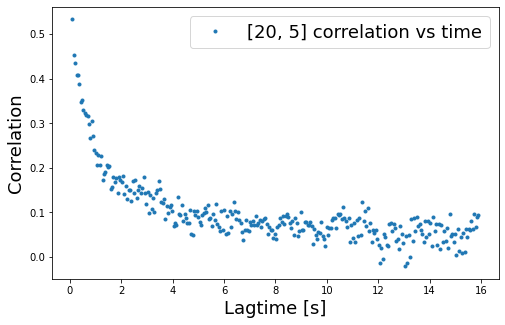

In [67]:
y=20
x=5
correlation_value=avg_correlation_single_px(corr_maps,[y,x],loadtRange_tau,t_range_tau,laglist_tau, laglist)
plot_correlation_vs_lagtime([y,x],correlation_value,lagtime_tau)

(0.0, 10.0)

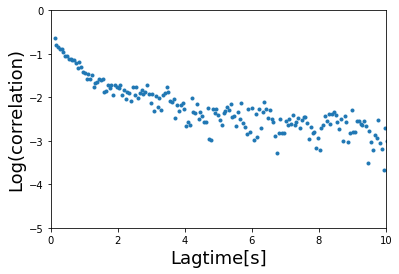

In [68]:
plt.plot(lagtime_tau,np.log(abs(np.array(correlation_value))),'.')
plt.xlabel('Lagtime[s]',fontsize=18)
plt.ylabel('Log(correlation)',fontsize=18)
plt.ylim(-5,0)
plt.xlim(0,10)

plateau is: 0.042841660128950035
tau is: 1.075978065338325
y = -0.92939 * x + -0.71864


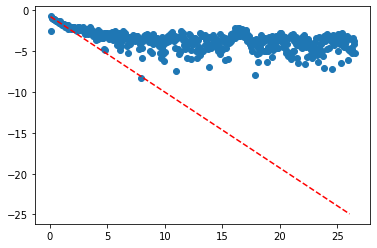

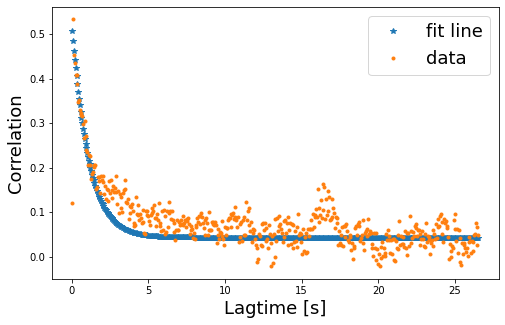

In [55]:
single_pixel_decay_constant(startidx=1,endidx=15)

<ipython-input-42-8796113ce559>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,5))


KeyboardInterrupt: 

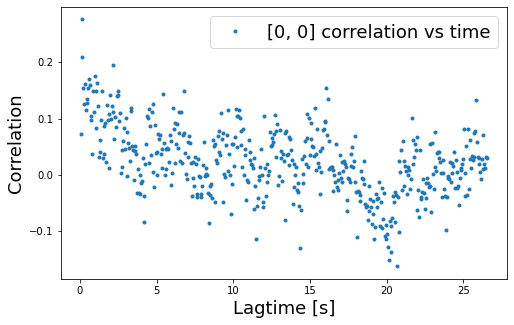

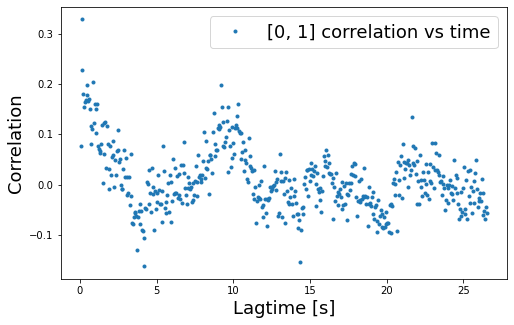

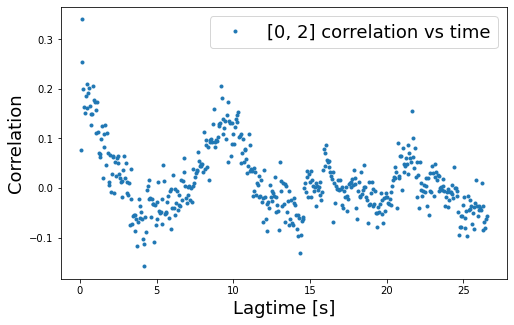

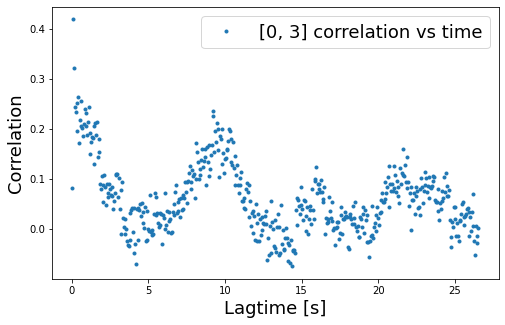

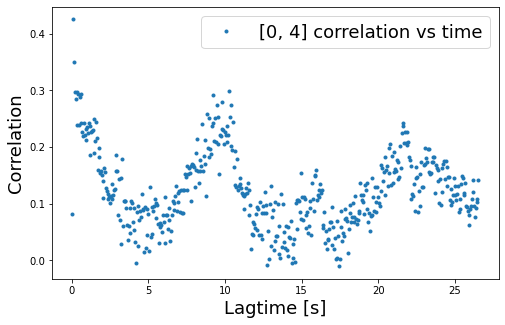

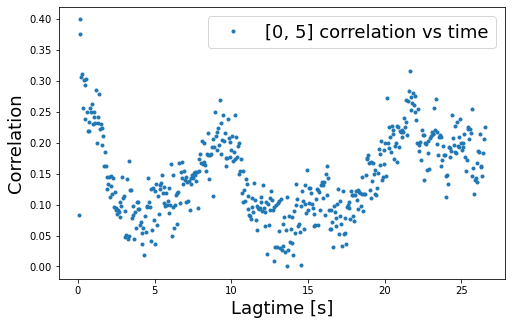

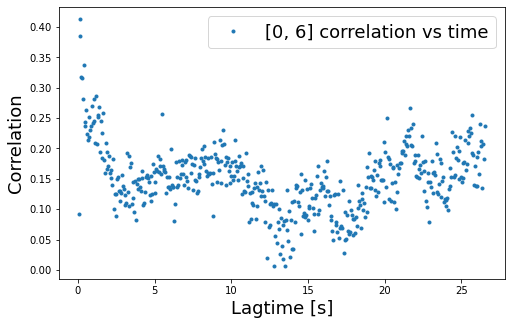

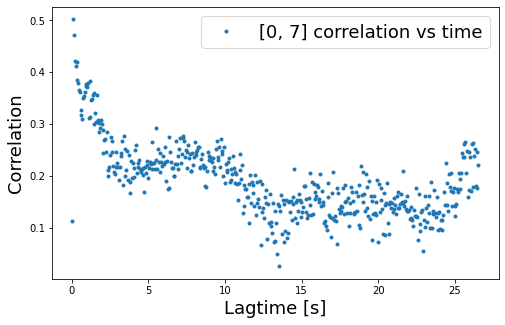

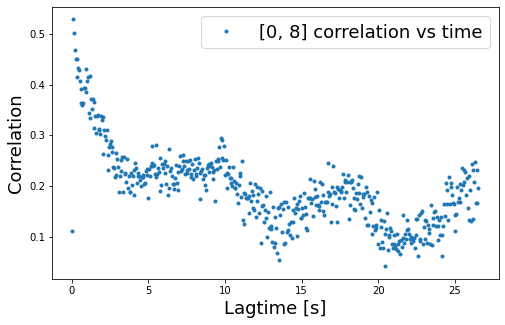

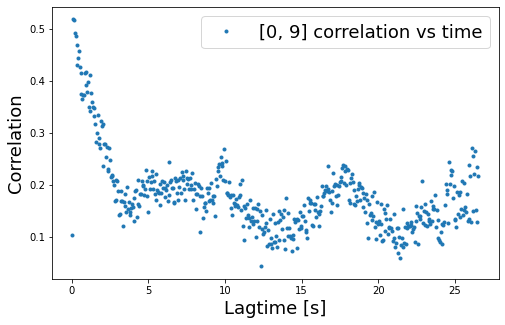

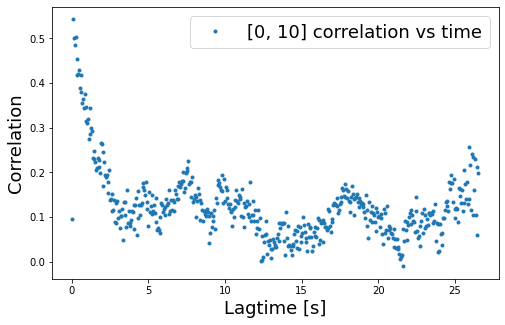

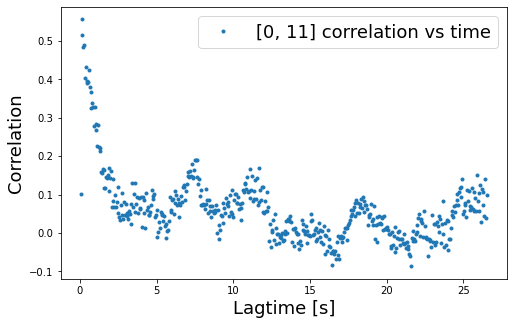

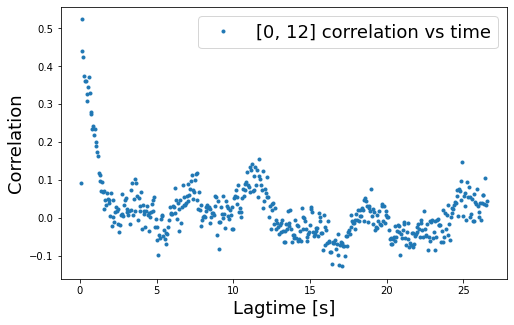

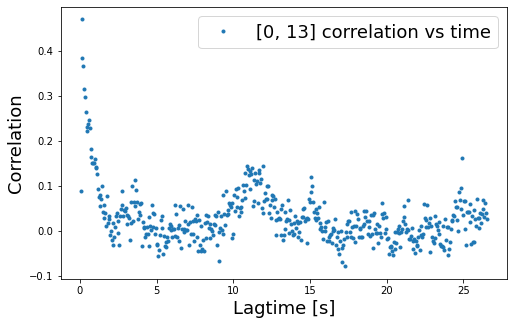

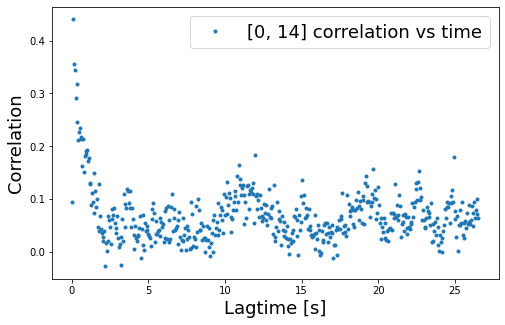

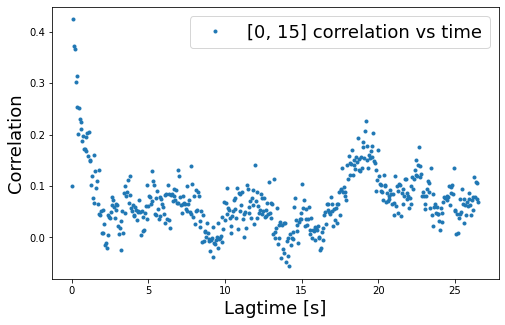

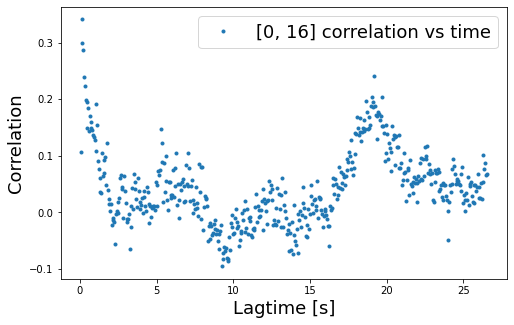

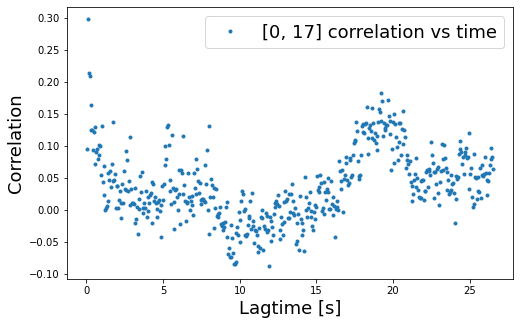

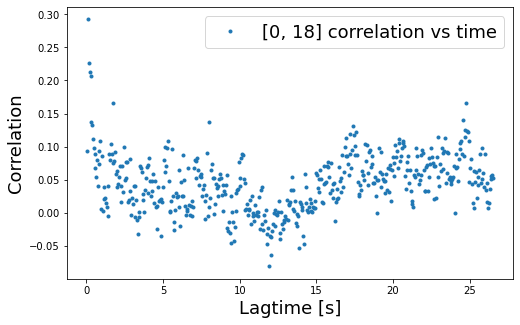

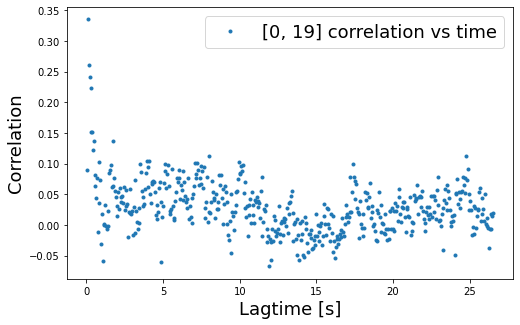

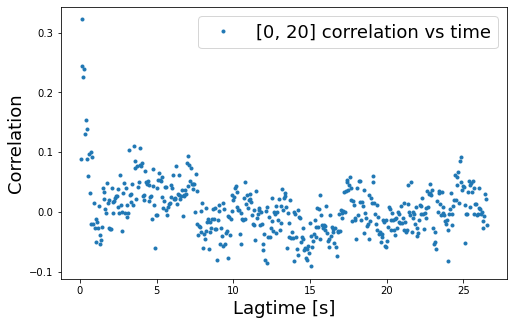

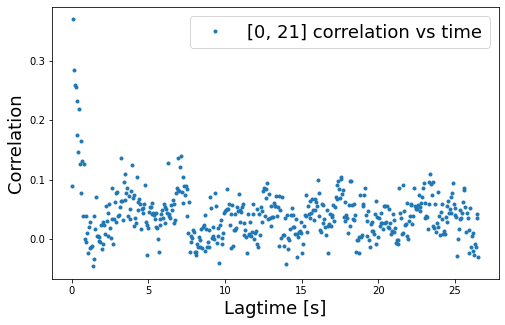

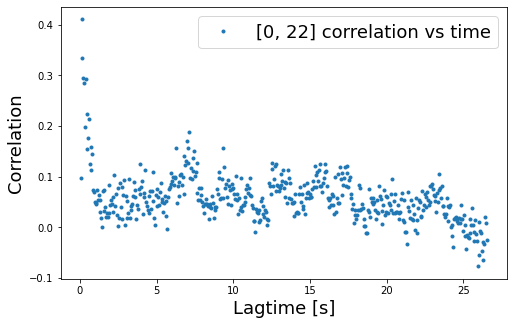

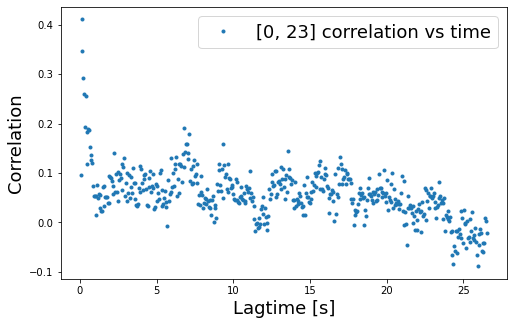

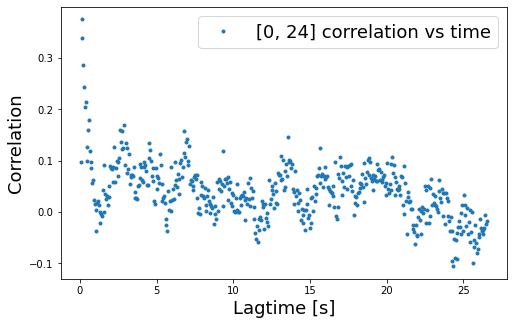

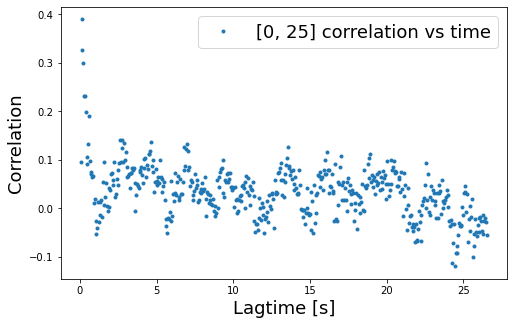

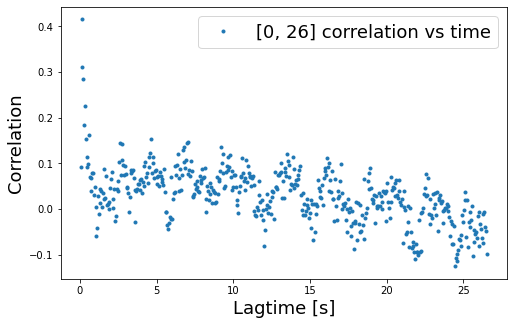

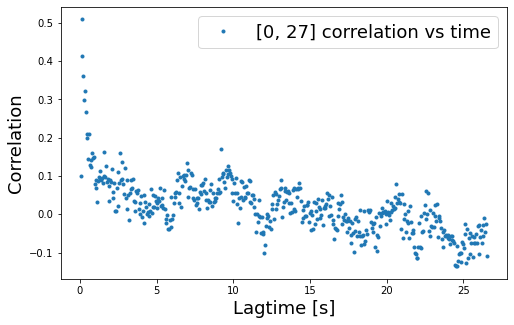

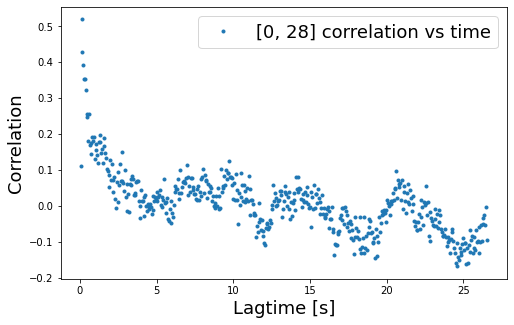

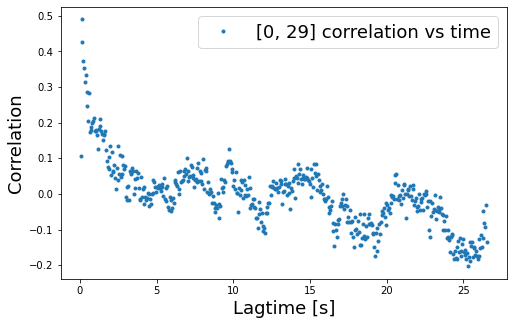

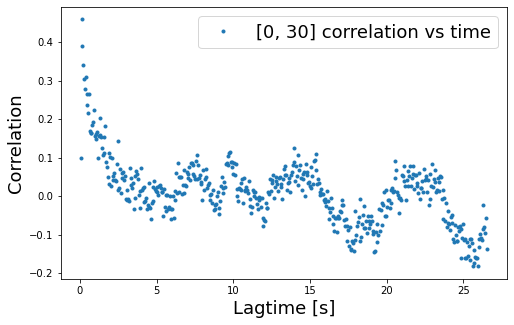

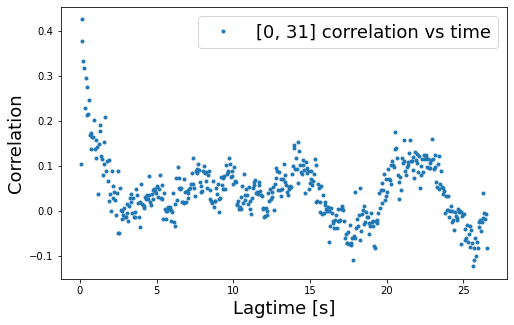

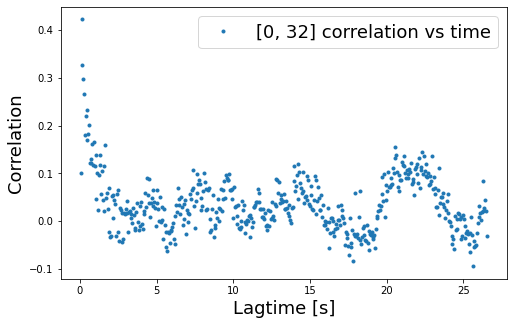

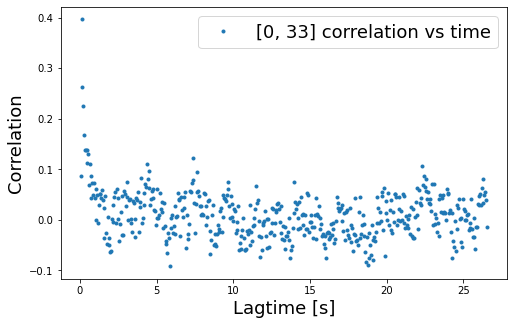

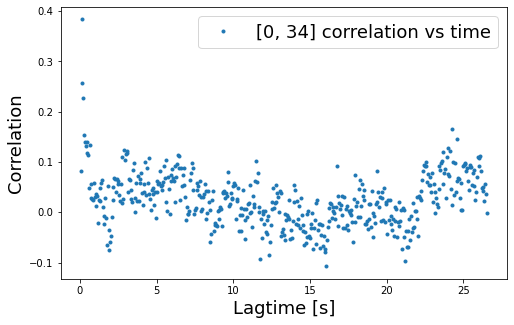

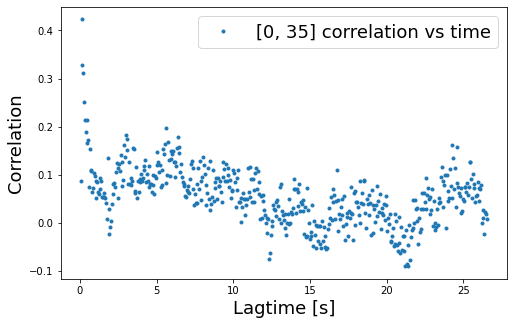

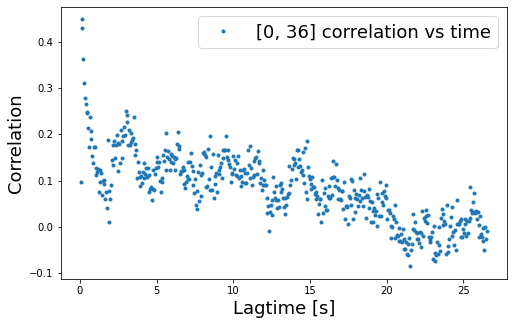

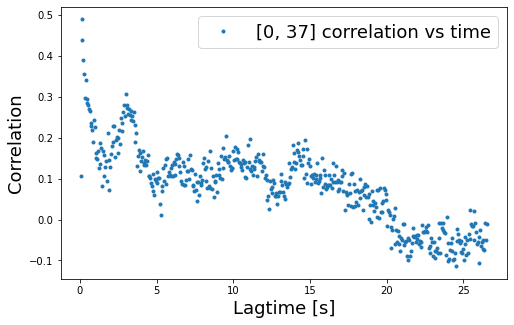

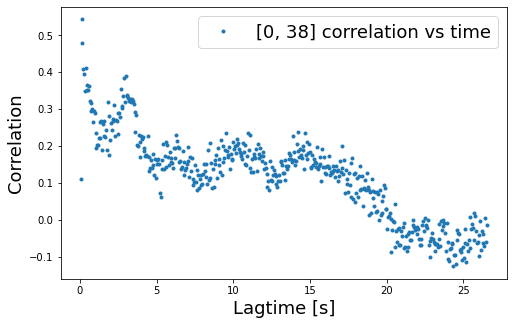

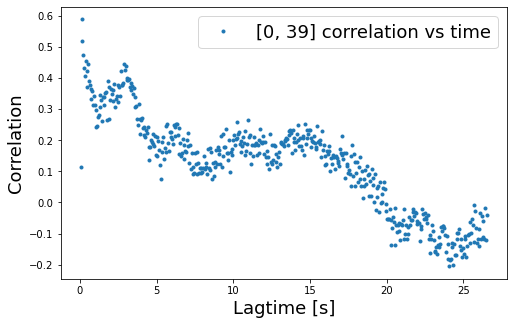

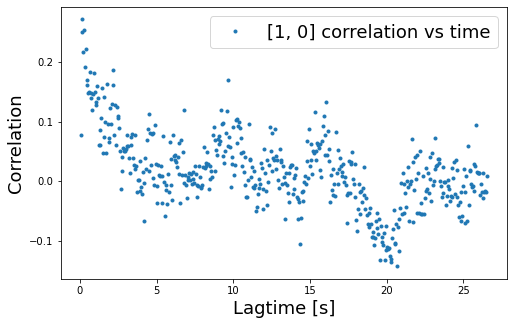

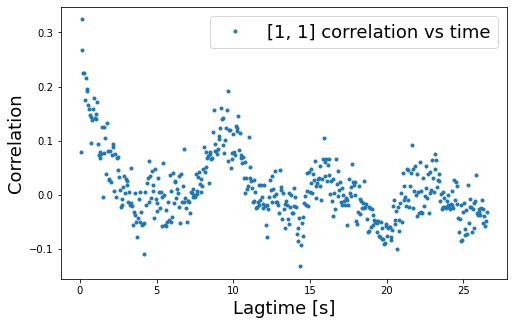

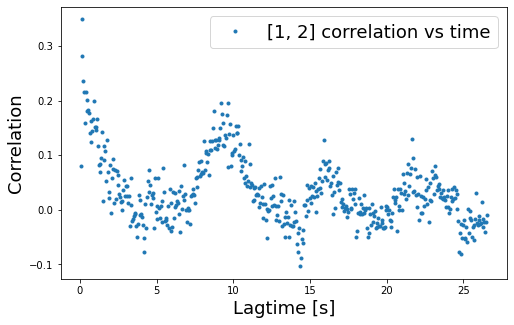

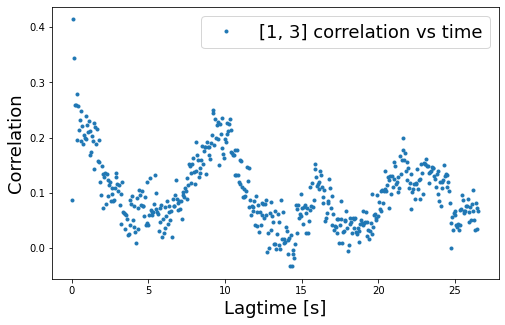

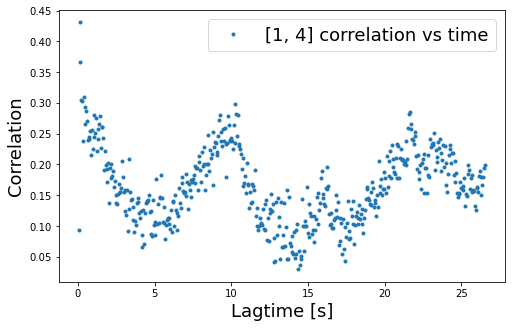

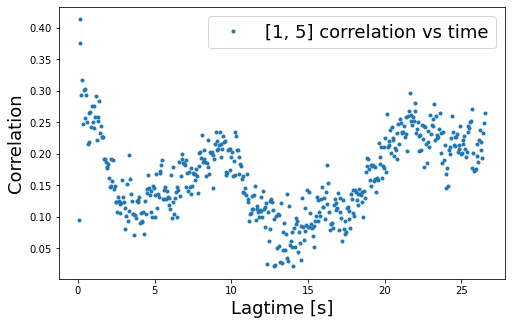

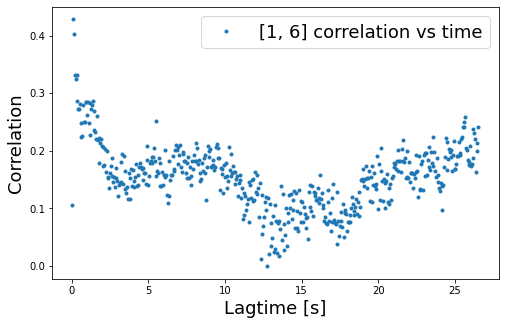

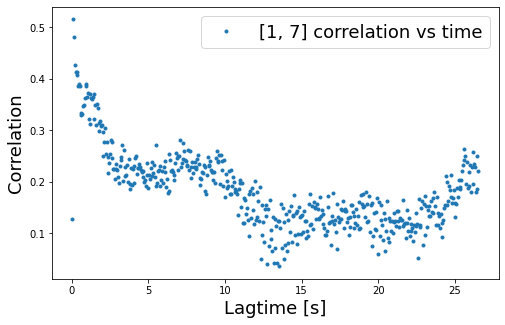

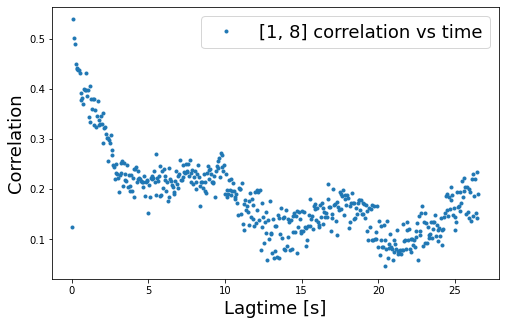

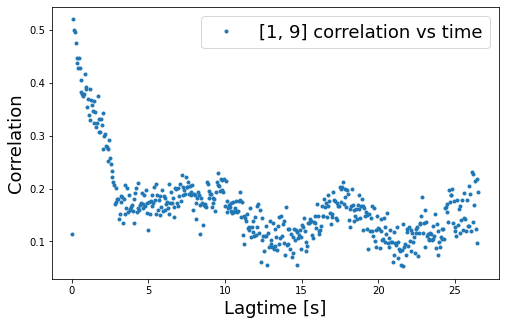

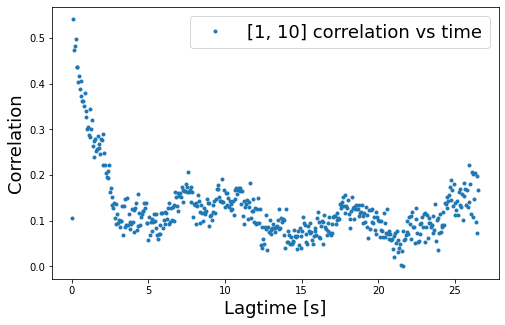

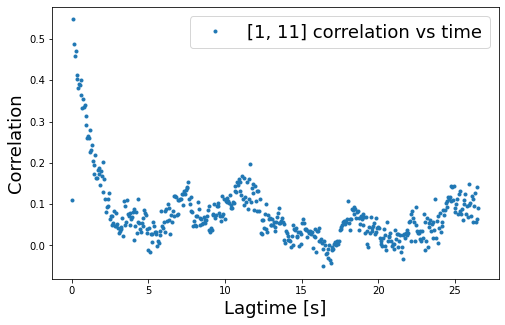

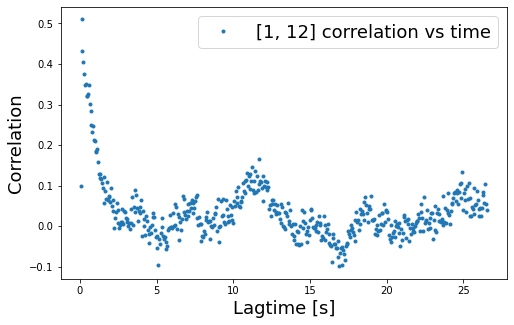

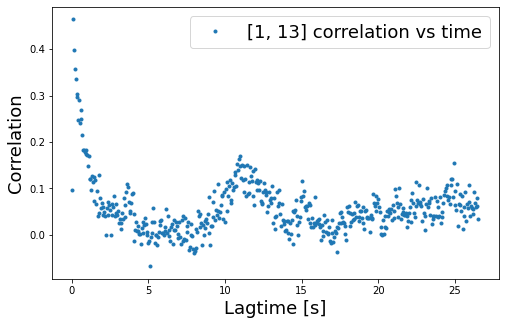

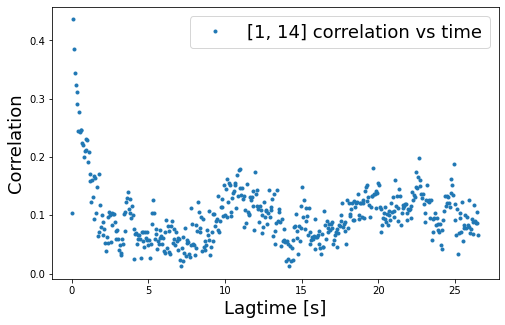

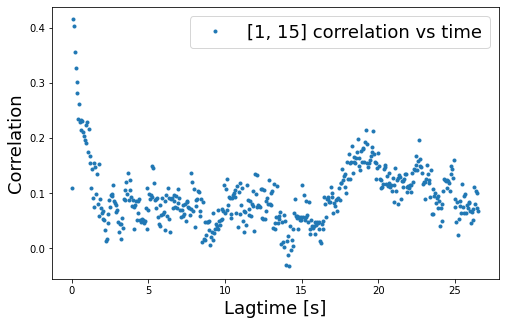

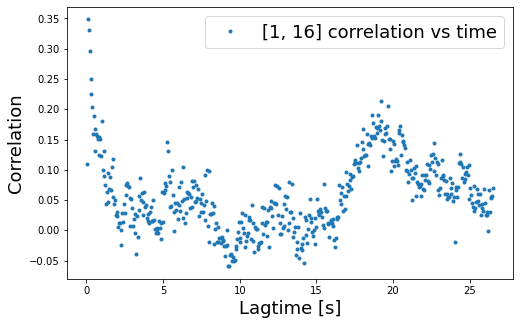

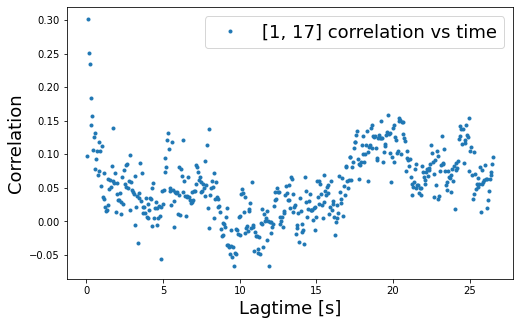

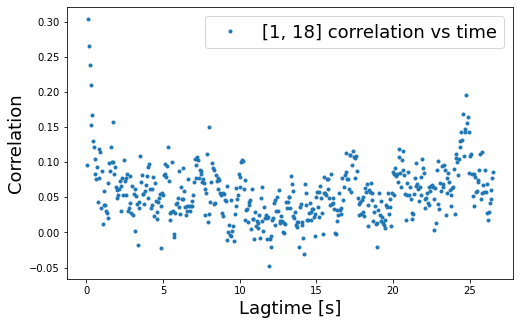

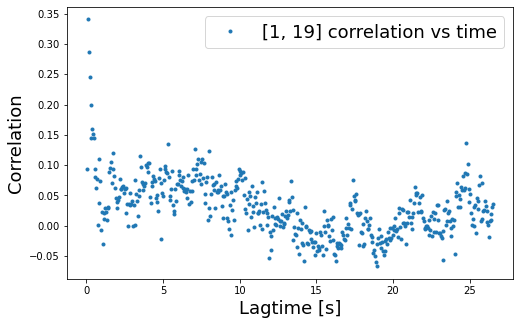

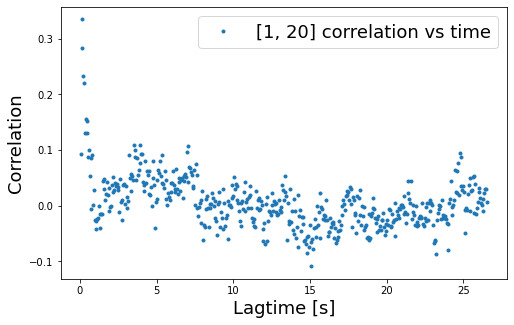

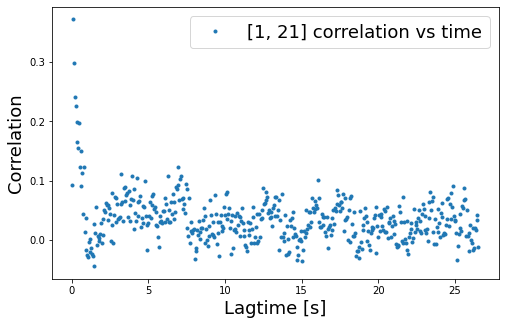

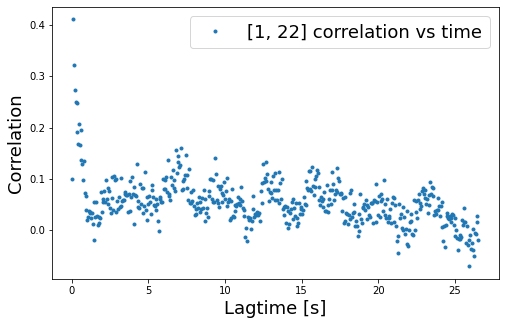

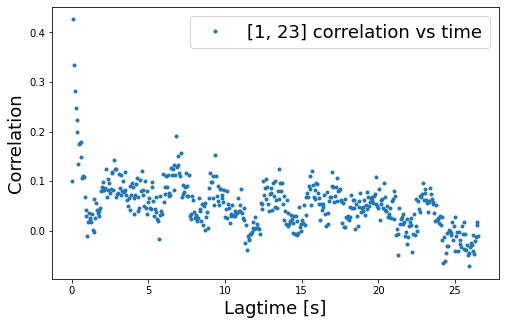

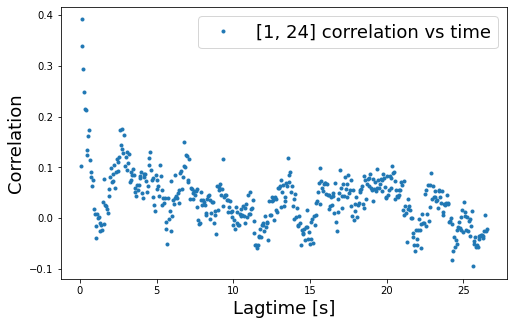

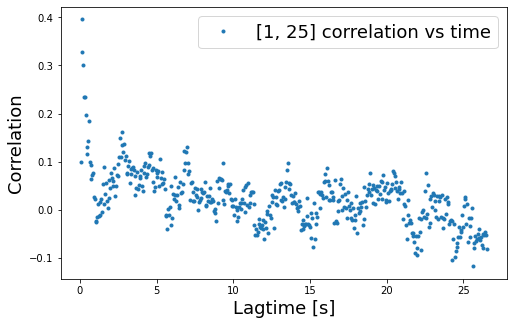

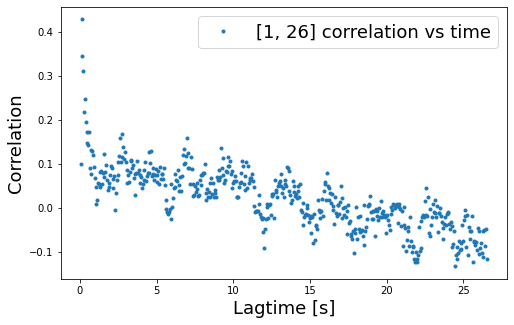

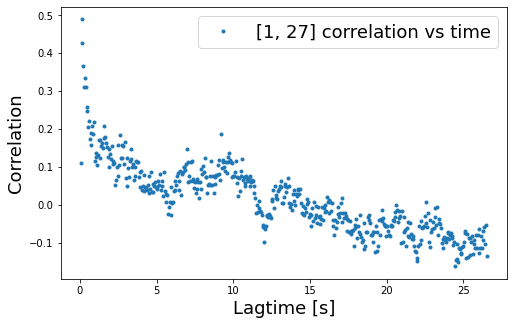

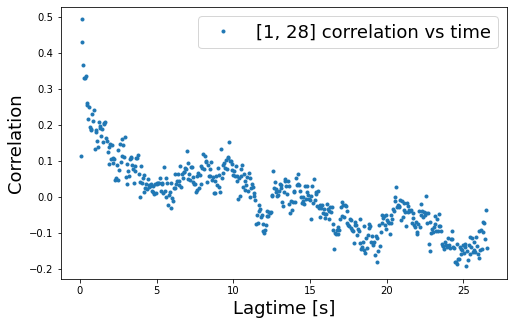

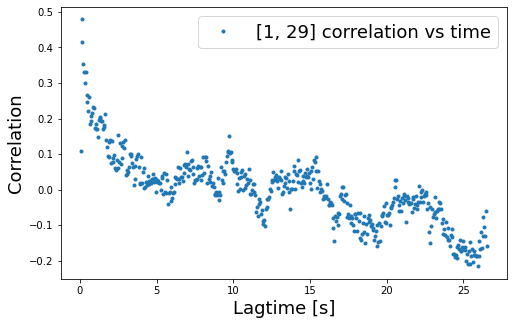

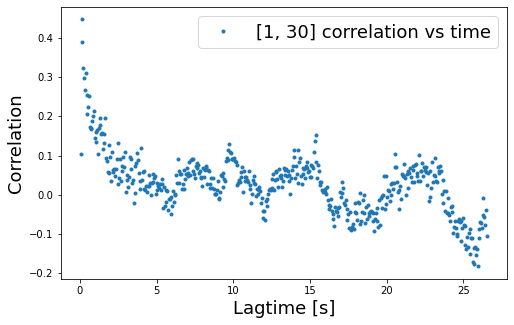

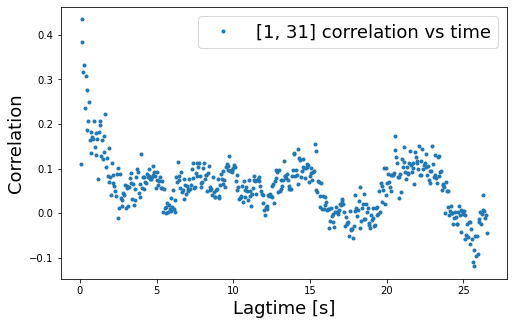

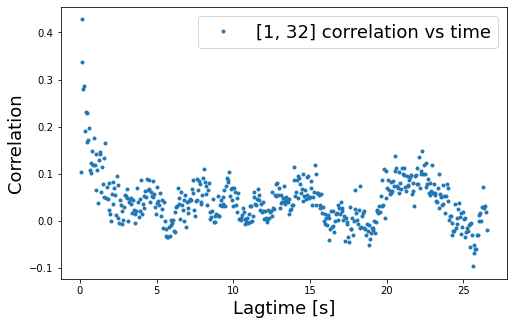

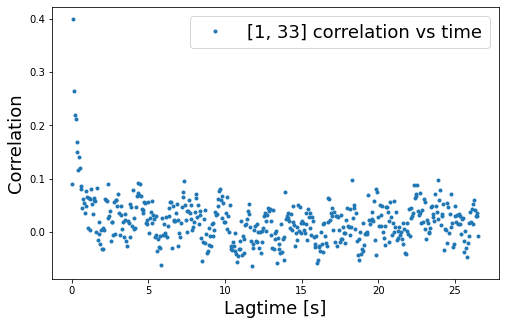

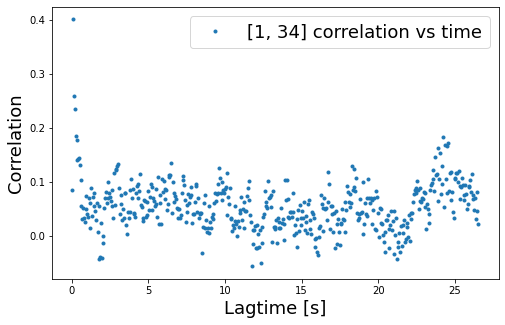

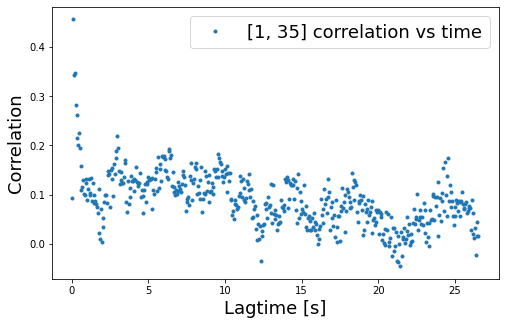

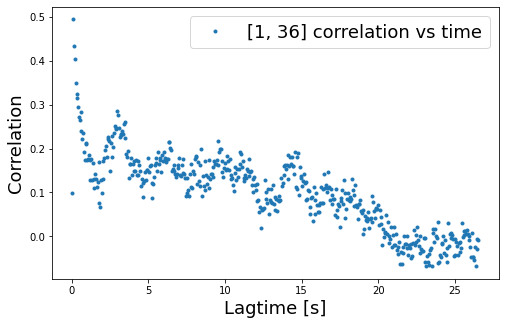

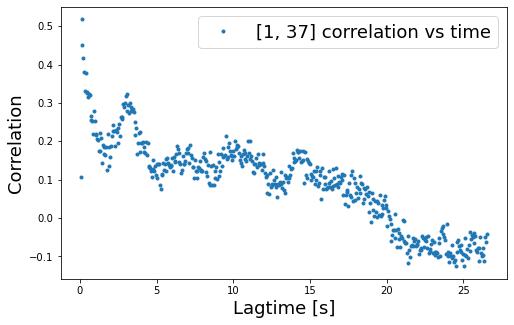

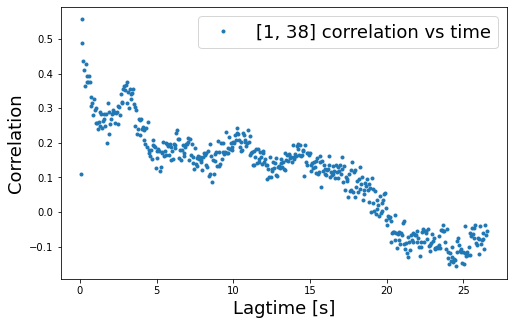

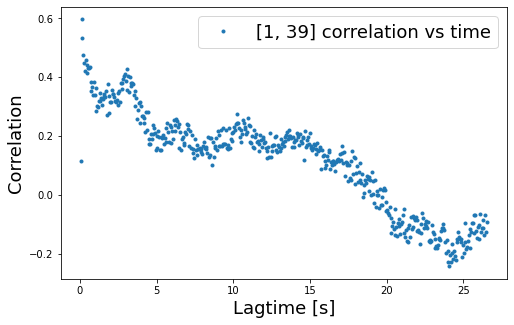

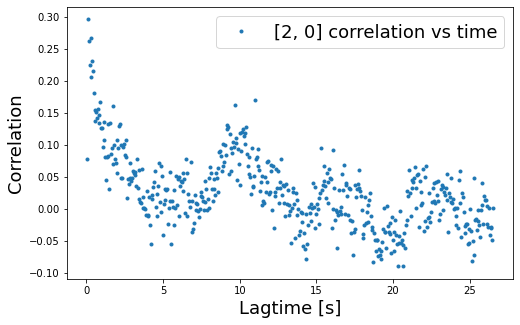

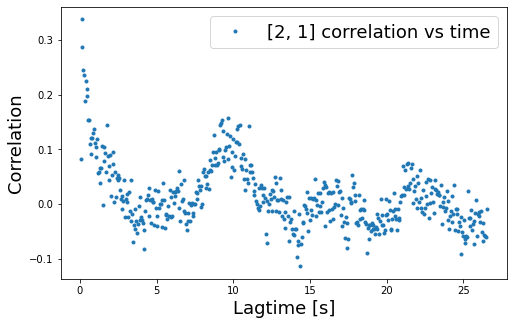

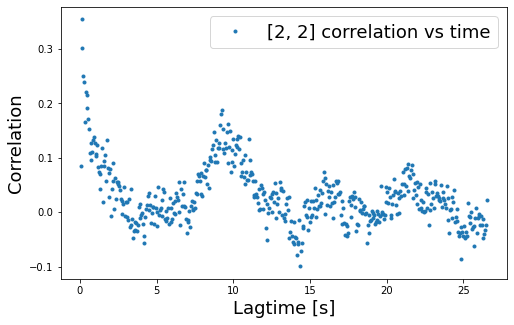

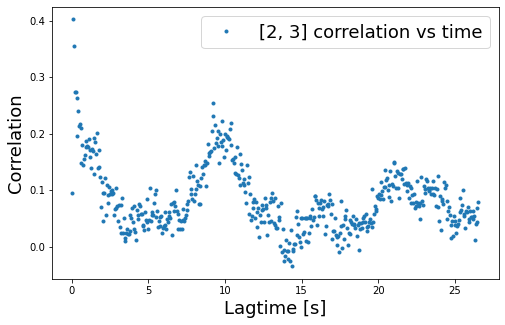

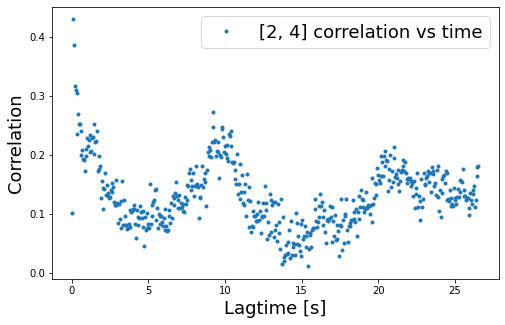

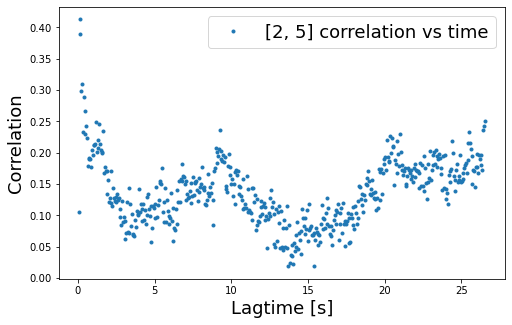

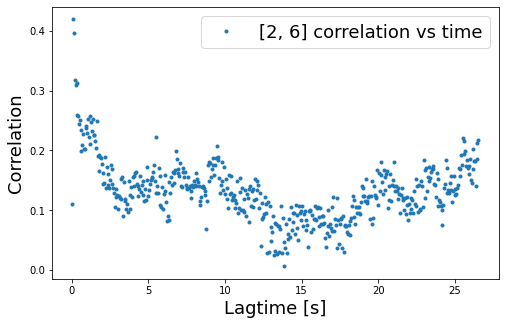

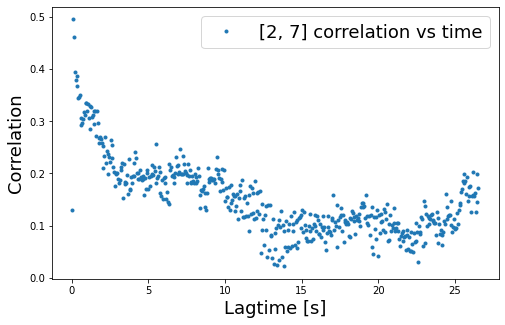

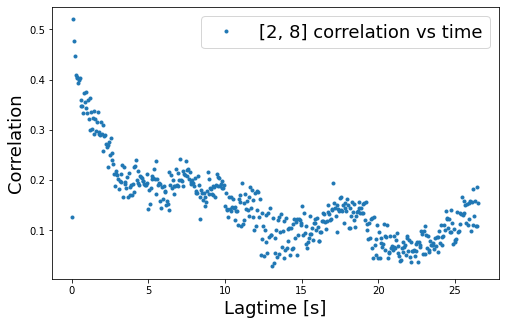

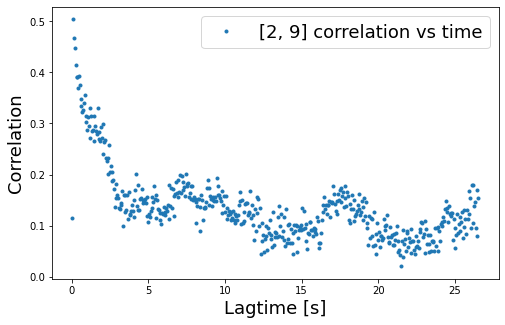

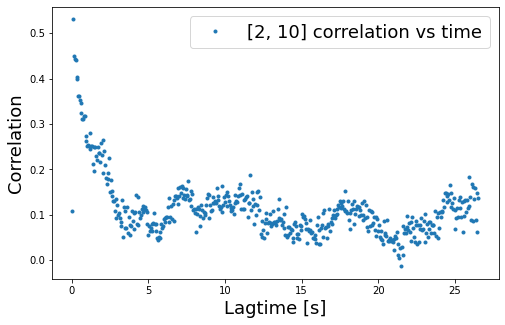

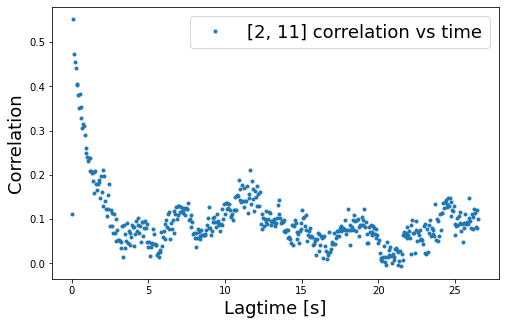

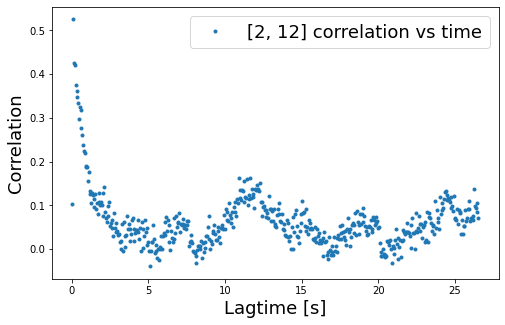

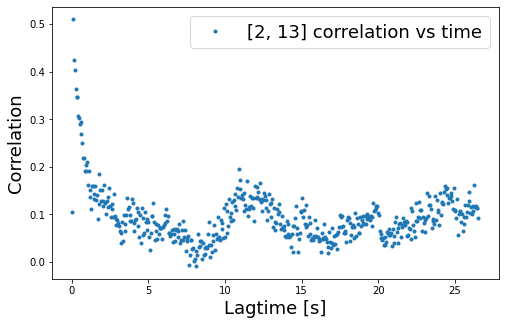

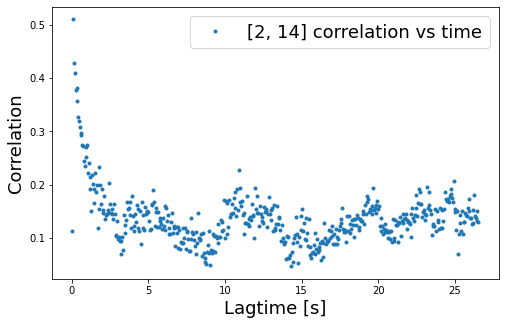

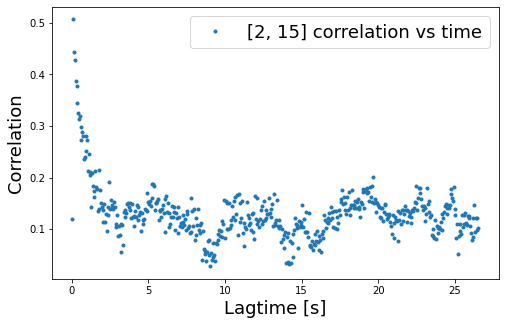

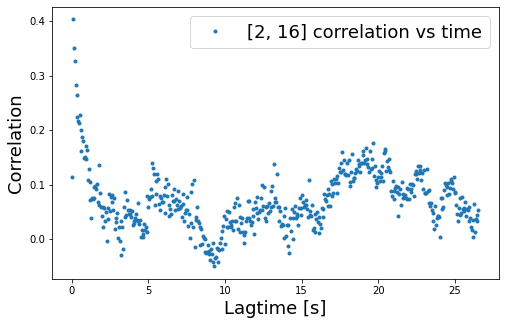

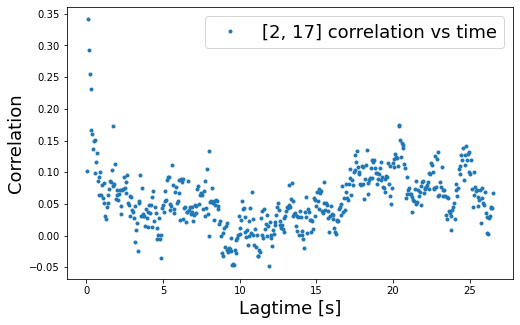

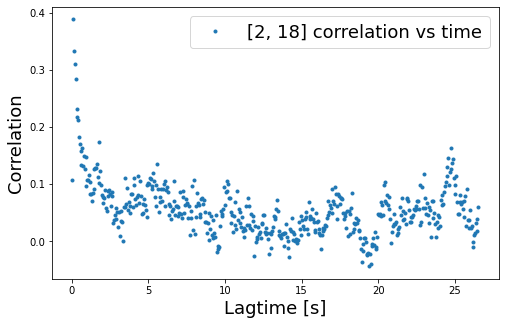

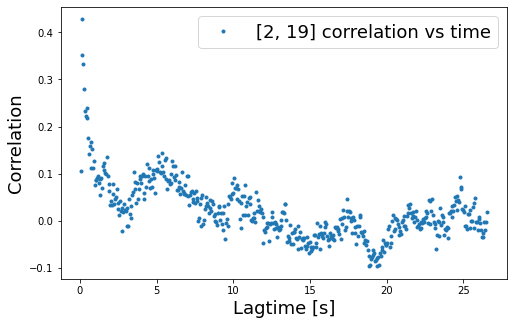

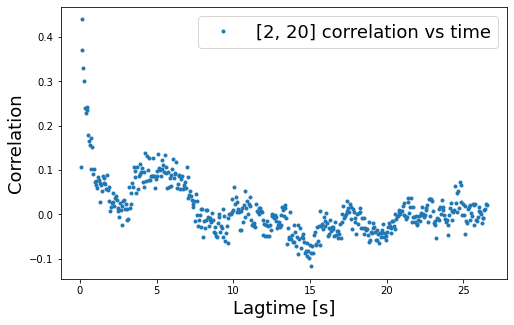

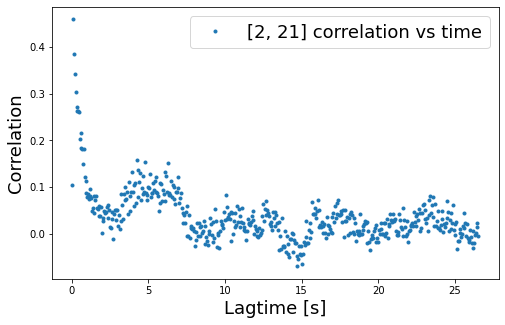

Error in callback <function flush_figures at 0x7f8c0a458af0> (for post_execute):


KeyboardInterrupt: 

In [42]:
for y in range(40):
    for x in range(40):
        correlation_value=avg_correlation_single_px(corr_maps,[y,x],loadtRange_tau,t_range_tau,laglist_tau, laglist)
        plt.figure(figsize=(8,5))
        plt.plot(lagtime_tau,correlation_value,'.',label=str([y,x])+' correlation vs time')
        plt.legend(fontsize=18)
        plt.xlabel("Lagtime [s]",fontsize=18)
        plt.ylabel("Correlation",fontsize=18)
        plt.savefig(str([y,x])+'_correlation.png')
        

## Computing average correlation decay

In [ ]:
# create pixel list
px_list_whole=[]
for y in range(testROI[3]):
    for x in range(testROI[2]):
        px_list_whole.append([y,x])

In [ ]:
numberT_average_tau=50
loadtRange_tau = [0,200,round(200/numberT_average_tau)]
t_range_tau=range(0,200,round(200/numberT_average_tau))
laglist_tau=list(range(1,900,1))
lagtime_tau= [element * framespeed for element in laglist_tau]

In [ ]:
def list_pixel_decay_constant(px_list,startidx=1,endidx=10):
    correlation_value=avg_correlation(corr_maps,px_list,loadtRange_tau,t_range_tau,laglist_tau, laglist)
    plt.figure()
    plot_correlation_vs_lagtime(correlation_value,lagtime_tau)
    length=len(correlation_value)
    plateau=np.mean(correlation_value[length-int(length/9):length])
    print("plateau is:",plateau)
    plt.figure()
    decay_time, a,b =fit_exponential_decay(plateau,correlation_value,lagtime_tau,startidx,endidx, plotBoolean=True)
    reconstruct(lagtime_tau,plateau,correlation_value,a,b)
    return correlation_value

In [ ]:
values=list_pixel_decay_constant(px_list_whole)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_tau[0:500],values[0:500],'.',label='24 hour aged')
plt.legend(fontsize=18)
plt.xlabel("Lagtime [s]",fontsize=18)
plt.ylabel("Correlation",fontsize=18)

In [ ]:
pickle.dump(values, open(foldername+'correlation_values.p',"wb"))

In [ ]:
pickle.dump(lagtime_tau, open(foldername+'lagtime.p',"wb"))

In [ ]:
values_7=pickle.load(open('/Volumes/wwyyrx/Wenyun/Speckle/Data_for_Yi/7houraged/correlation_values.p',"rb"))

In [ ]:
lag_7=pickle.load(open('/Volumes/wwyyrx/Wenyun/Speckle/Data_for_Yi/7houraged/lagtime.p',"rb"))

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_tau[0:300],values[0:300],'.',label='24 hour aged')
plt.plot(lag_7[0:300],values_7[0:300],'.',label='7 hour aged')
plt.legend(fontsize=18)
plt.xlabel("Lagtime [s]",fontsize=18)
plt.ylabel("Correlation",fontsize=18)